# Textured AR Quality Control Image Recognition

In [1]:
%matplotlib inline

# standard imports
from datetime import datetime as dt
import json
import os
from pathlib import Path

# external dependencies
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")


TensorFlow version: 2.15.0
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
def circular_mask(arr:np.ndarray, center:tuple, radius:float) -> np.ndarray:
    #print("in shape: ", arr.shape)
    dx, dy = arr.shape[0], arr.shape[1]

    out_mask = np.zeros_like(arr)
    for x in range(dx):
        for y in range(dy):
            if (x - center[0])**2 + (y - center[1])**2 <= radius**2:
                out_mask[x, y] = arr[x, y]
    #print("out shape: ", out_mask.shape)
    return out_mask

Pass: 1365  Fail: 970
label shape: (2,), sample shape: (512, 512)
sample type: <class 'numpy.ndarray'>, datatype: uint8
max: 255, min: 2
276 350 265


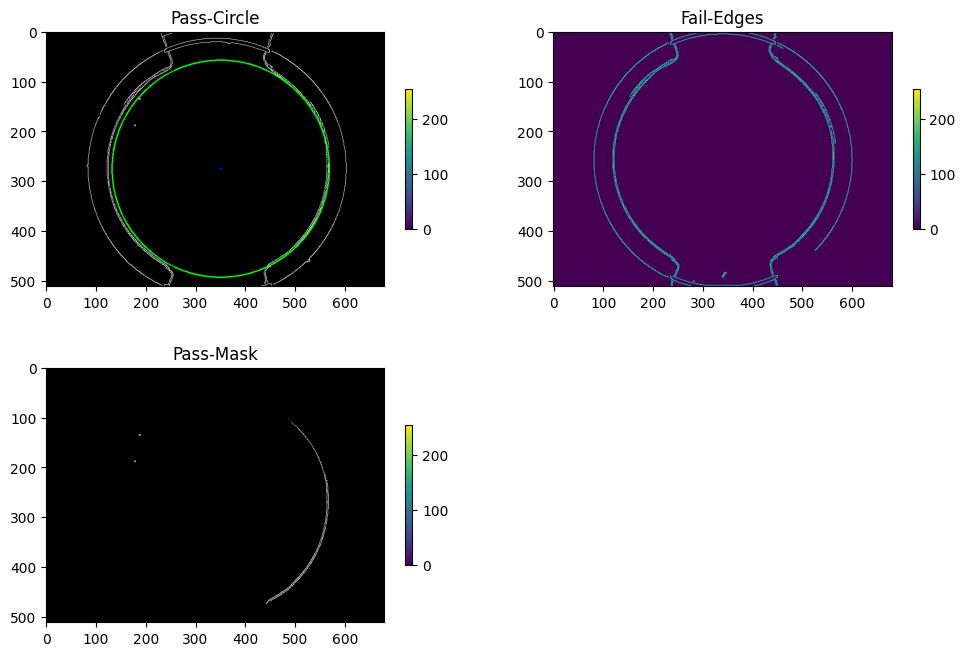

In [3]:
# inspect the training data and plot a sample image
with np.load(Path(r'./data/dataset_01312024.npz')) as ds:
    images, labels, classes = (ds['images'], ds['labels'], ds['classes'])

# calculate the sample distribution
passed, failed = [], []
for img, lbl in zip(images, labels):
    if classes[np.argmax(lbl)] == 'pass':
        passed.append(img)
    else:
        failed.append(img)

print(f"Pass: {len(passed)}  Fail: {len(failed)}")

# take a sample image, scaled to 16-bit int
sample = passed[0]
sample1 = failed[0]/255.0

# print sample info
print(f"label shape: {labels[0].shape}, sample shape: {sample.shape}")
print(f"sample type: {type(sample)}, datatype: {sample.dtype}")
print(f"max: {np.max(sample)}, min: {np.min(sample)}")

sample = cv.resize(sample, (680, 512))
s_blur = cv.GaussianBlur(sample, (3, 3), 0)
sample = cv.Canny(image=s_blur, threshold1=25, threshold2=100)

detected_circles = cv.HoughCircles(sample,
                                   cv.HOUGH_GRADIENT,
                                   1,
                                   20,
                                   param1=50,
                                   param2=30,
                                   minRadius=250,
                                   maxRadius=280)
detected_circles = np.uint16(np.around(detected_circles))

sample = cv.cvtColor(sample, cv.COLOR_GRAY2BGR)

# mask the first circle found
cir = detected_circles[0, :][0]
y, x, r = cir[0], cir[1], cir[2]
print(x, y, r)
msk = circular_mask(sample, (x, y), r*.825)

for pt in detected_circles[0, :]:
        a, b, r = pt[0], pt[1], pt[2]

        # Draw the circumference of the circle.
        cv.circle(sample, (a, b), int(r*.825), (0, 255, 0), 2)

        # Draw a small circle (of radius 1) to show the center.
        cv.circle(sample, (a, b), 1, (0, 0, 255), 3)


sample1 = cv.resize(failed[0], (680, 512))
s1_blur = cv.GaussianBlur(sample1, (3, 3), 0)
sample1 = cv.Canny(image=s1_blur, threshold1=25, threshold2=100)

# plot a sample image from the passing samples
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1)
plt.title("Pass-Circle")
img = plt.imshow(sample, vmin=np.min(sample), vmax=np.max(sample))
fig.colorbar(img, ax=ax, shrink=0.5)

# plot a sample from the failing samples
ax1 = plt.subplot(2, 2, 2)
plt.title("Fail-Edges")
img1 = plt.imshow(sample1, vmin=np.min(sample), vmax=np.max(sample))
fig.colorbar(img1, ax=ax1, shrink=0.5)

# plot a masked version of the first image
ax2 = plt.subplot(2, 2, 3)
plt.title("Pass-Mask")
img2 = plt.imshow(msk, vmin=np.min(sample), vmax=np.max(sample))
fig.colorbar(img2, ax=ax2, shrink=0.5)

In [4]:
# create a data processing pipeline function
def data_pipeline(ds_path, batch_size=None, seed=123):
    """ Process the dataset """
    print('-'*80)

    np.random.seed(seed)

    print("Reading dataset from file..")
    with np.load(ds_path) as ds:
        images, labels, classes = (ds['images'], ds['labels'], ds['classes'])

    print("Resizing images..")
    images = list(map(lambda x: cv.resize(x, (680//2, 512//2)), images))

    # edge detection
    #print("Performing edge detection..")
    #images = list(map(lambda x: cv.GaussianBlur(x, (3, 3), 0), images))
    #images = list(map(lambda x: cv.Canny(image=x, threshold1=25, threshold2=100), images))

    # hough circles
    #print("Extracting boundaries..")
    #circles  = list(map(
    #    lambda x: cv.HoughCircles(x, cv.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=250, maxRadius=280), images))
    #circles = [detected[0, :][0] if detected is not None else None for detected in circles]
    #for c in circles:
    #    print(c)

    # mask the images
    #print("Masking images..")
    #msk = []
    #for i, im in enumerate(images):
    #    if circles[i] is not None:
    #        msk = circular_mask(im, (circles[i][1], [i][0]), circles[i][2])

    # scale images between 0-1 (8-bit integers)
    print("Scaling images..")
    images = list(map(lambda x: x / 255.0, images))

    # expand images to have dimension (H x W x D)
    print("Setting image dimensions..")
    images = list(map(lambda x: np.expand_dims(x, axis=2), images))

    # shuffle the dataset
    print("Shuffling dataset..")
    shuffled_idx = np.random.permutation(len(images))
    images, labels = np.asarray(images), np.asarray(labels)
    images[:] = images[shuffled_idx]
    labels[:] = labels[shuffled_idx]

    if batch_size is not None:
        n_batches = np.shape(images)[0] // batch_size
        print(f"Generating {n_batches} batches.")
        batched_images, batched_labels = [], []
        a = 0
        b = batch_size
        for i in range(0, n_batches):
            batched_images.append(np.asarray(images[a:b]))
            batched_labels.append(np.asarray(labels[a:b]))
            a += batch_size
            b += batch_size
        images, labels = np.asarray(batched_images), np.asarray(batched_labels)

    print("x data: ")
    print(images.shape, images[0].shape, images.dtype, type(images))
    print("y data : ")
    print(labels.shape, labels[0].shape, labels.dtype, type(labels))

    print('-'*80)
    # return the dataset object
    return images, labels

# process the datasets
x_data, y_data = data_pipeline(Path(r'./data/dataset_01312024.npz'))

--------------------------------------------------------------------------------
Reading dataset from file..
Resizing images..
Scaling images..
Setting image dimensions..
Shuffling dataset..
x data: 
(2335, 256, 340, 1) (256, 340, 1) float64 <class 'numpy.ndarray'>
y data : 
(2335, 2) (2,) float32 <class 'numpy.ndarray'>
--------------------------------------------------------------------------------


In [5]:
# split into training/validatio/test datasets
x_train, y_train = x_data[:1865], y_data[:1865]
x_val, y_val = x_data[1866:2100], y_data[1866:2100]
x_test, y_test = x_data[2101:], y_data[2101:]

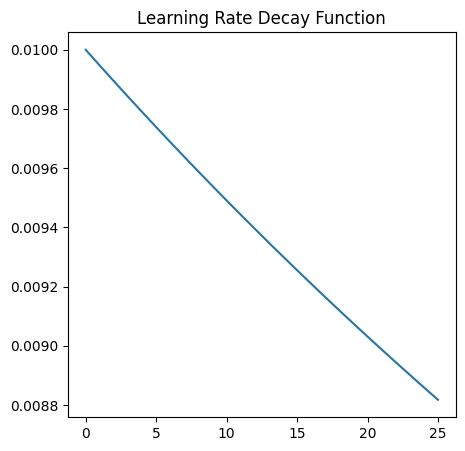

In [6]:
# set up the learning rate decay
epochs = 25

# define learning rate decay
lr_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.01, decay_steps=len(x_train), decay_rate=10, staircase=False
)

# plot the learning rate
steps = np.linspace(0, epochs)

# plot learning rate decay function
plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
plt.title(f"Learning Rate Decay Function")
plt.plot(steps, lr_decay(steps))

In [7]:
num_classes = 2
k_size = (3, 3)
p_size = (2, 2)
stride = None #(1, 1)

# build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(512//2, 680//2, 1)),

    tf.keras.layers.Conv2D(filters=4, kernel_size=k_size, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size, strides=stride),

    tf.keras.layers.Conv2D(filters=8, kernel_size=k_size, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size, strides=stride),

    tf.keras.layers.Conv2D(filters=16, kernel_size=k_size, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size, strides=stride),

    tf.keras.layers.Conv2D(filters=24, kernel_size=k_size, padding="same", activation="relu"),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size, strides=stride),

    tf.keras.layers.Conv2D(filters=32, kernel_size=k_size, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size, strides=stride),

    tf.keras.layers.Conv2D(filters=64, kernel_size=k_size, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size, strides=stride),

    tf.keras.layers.Conv2D(filters=128, kernel_size=k_size, padding="same", activation="relu"),
    #tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size, strides=stride),

    tf.keras.layers.Conv2D(filters=256, kernel_size=k_size, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=p_size, strides=stride),

    #tf.keras.layers.Conv2D(filters=512, kernel_size=k_size, padding="same", activation="relu"),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPool2D(pool_size=p_size, strides=stride),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),

    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),

    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),

    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='relu'),

    tf.keras.layers.Dense(num_classes, activation='softmax'),
])


model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr_decay),
    metrics=['accuracy'])

# show the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 340, 4)       40        
                                                                 
 batch_normalization (Batch  (None, 256, 340, 4)       16        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 170, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 170, 8)       296       
                                                                 
 batch_normalization_1 (Bat  (None, 128, 170, 8)       32        
 chNormalization)                                                
                                                      

In [8]:
# create a timestamp for file naming
curr_timestamp = dt.now().strftime("%Y%m%d_%H%M%S")
os.mkdir(os.path.join('./models/', curr_timestamp))

# add checkpoint callback
# monitor the validation loss, saving only the best model
# only begin saving when loss is < initial_value_threshold
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join('./models/', curr_timestamp, 'model.h5'),
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    initial_value_threshold=0.65
)

# add early stopping callback
# loss must change by at least .01
# stop after 2 epochs if no improvement
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=.01,
    patience=10,
    verbose=1,
    mode='auto'
)


# run the training
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=25,
    verbose=1,
    callbacks=[checkpoint, early_stop])

# dump history to json file
json.dump(history.history, open(os.path.join('./models/', curr_timestamp, 'history.json'), 'w'))

Epoch 1/25


59/59 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.5239
Epoch 1: val_loss did not improve from 0.65000
59/59 [==============================] - 7s 92ms/step - loss: 0.7359 - accuracy: 0.5239 - val_loss: 0.6909 - val_accuracy: 0.5726
Epoch 2/25
58/59 [============================>.] - ETA: 0s - loss: 0.6830 - accuracy: 0.5754
Epoch 2: val_loss did not improve from 0.65000
59/59 [==============================] - 5s 85ms/step - loss: 0.6827 - accuracy: 0.5764 - val_loss: 0.6907 - val_accuracy: 0.5726
Epoch 3/25
58/59 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5679
Epoch 3: val_loss did not improve from 0.65000
59/59 [==============================] - 5s 85ms/step - loss: 0.6844 - accuracy: 0.5678 - val_loss: 0.6935 - val_accuracy: 0.4786
Epoch 4/25
58/59 [============================>.] - ETA: 0s - loss: 0.6849 - accuracy: 0.5690
Epoch 4: val_loss did not improve from 0.65000
59/59 [==============================] - 5s 

## Visualizing the Filters
This section visualized the filter of the model after training. This helps to see what/how the model is learning. The simplest visualization is to plot the learned filters directly. In terms of neural networks, learned filters are simple weights, but because of the 2-D structure of the filters, weights have a spatial relationship and plotting them as 2-D images can be helpful.

The first step is to review the filters in the model. The layers can be accessed via the `model.layers` property of the model and each layer has a `layer.name` property. We then use `model.get_weights()` to retrieve the filters and bias values.

Reference:
https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [9]:
print("idx\tname\t\tshape")
print('-'*50)
for i, layer in enumerate(model.layers):
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print(i, '\t', layer.name, '\t', filters.shape)


idx	name		shape
--------------------------------------------------
0 	 conv2d 	 (3, 3, 1, 4)
3 	 conv2d_1 	 (3, 3, 4, 8)
6 	 conv2d_2 	 (3, 3, 8, 16)
9 	 conv2d_3 	 (3, 3, 16, 24)
12 	 conv2d_4 	 (3, 3, 24, 32)
15 	 conv2d_5 	 (3, 3, 32, 64)
18 	 conv2d_6 	 (3, 3, 64, 128)
21 	 conv2d_7 	 (3, 3, 128, 256)


We can see that the convolutional layers use `3x3` filters. Since we are working with grayscale images, each filter in the first layer only has a depth of 1. As we go deeper into the network, the depth of each filter grows due to the max pooling and the convolutional, or "feature extraction", layers act as a funnel that gradually change the dimensions of the input.

 Next, we'll retrieve the filters from the first hidden layer then normalize their values to make them easier to visualize. After, we can plot them using matplotlib.

(3, 3, 16)


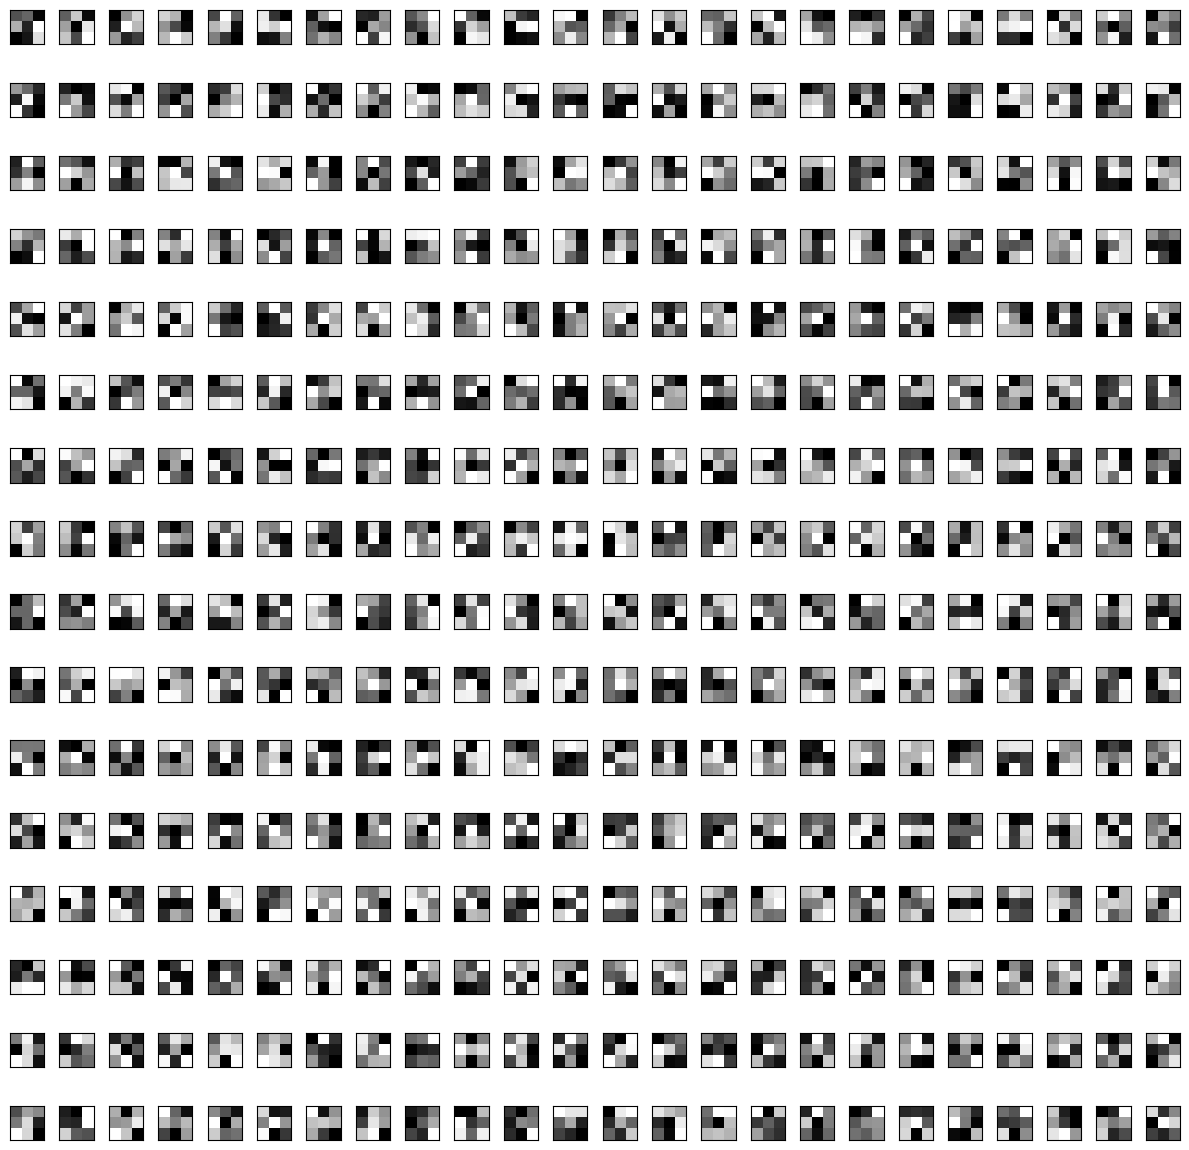

In [61]:
# get weights from a convlutional layer using it's index
filters, biases = model.layers[9].get_weights()

# normalize from 0-1
f_min, f_max = filters.min(), filters.max()
filters = (filters -f_min) / (f_max - f_min)

n_filters, ix = filters.shape[3], 1

# print the shape of the filters in the layer
print(np.shape(filters[:, :, :, 0]))

# create a new figure
fig = plt.figure(figsize=(12, 12))

# iterate through the filters
for i in range(n_filters):
    # get the filter
    f = filters[:,:,:,i]

    depth = np.shape(f)[2]
    for j in range(depth):

        ax = plt.subplot(depth, n_filters, ix)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(f[:,:,j], cmap='gray')
        ix += 1

plt.tight_layout()
plt.show()

## Visualizing the Feature Maps
Visualizing the feature map for an input image helps to understand what features of the input are detected or preserved in the feature maps. Feature maps closer to the input layer are used to detect small, fine-grained features, whereas the maps further away from the input detect more general features.

In [11]:
print("idx\tname\t\toutput")
print('-'*50)

# show the shapes of the feature maps
for i, layer in enumerate(model.layers):
    if 'conv' not in layer.name:
        continue
    print(i, '\t', layer.name, '\t', layer.output.shape)

idx	name		output
--------------------------------------------------
0 	 conv2d 	 (None, 256, 340, 4)
3 	 conv2d_1 	 (None, 128, 170, 8)
6 	 conv2d_2 	 (None, 64, 85, 16)
9 	 conv2d_3 	 (None, 32, 42, 24)
12 	 conv2d_4 	 (None, 16, 21, 32)
15 	 conv2d_5 	 (None, 8, 10, 64)
18 	 conv2d_6 	 (None, 4, 5, 128)
21 	 conv2d_7 	 (None, 2, 2, 256)


We'll generate a new model that contains a subset of the layers of our full architecture. The input will be the same as the initial model input, but the output will be the output from a chosen convolutional layer which is the activation of the feature map. We can use a random input image chosen from the training dataset as our test input.

(256, 340, 1)


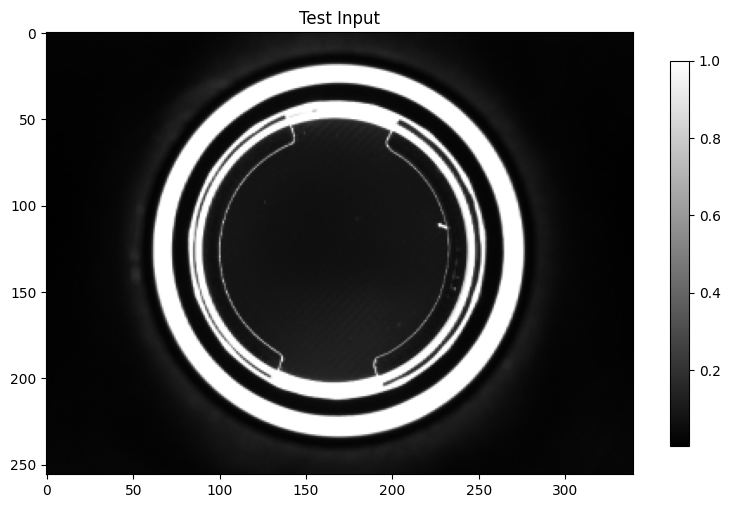

In [37]:
# select a training image and plot it
test_img = x_train[175]
print(np.shape(test_img))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
plt.title("Test Input")
img = plt.imshow(test_img, vmin=np.min(test_img), vmax=np.max(test_img), cmap='gray')
fig.colorbar(img, ax=ax, shrink=0.5)
plt.tight_layout()
plt.show()

In [57]:
# the last layer we want to see the feature map for
lyr_idx = 9

# create the model subset
outputs = [model.layers[i].output for i in range(lyr_idx+1)]
sub_model = tf.keras.Model(inputs=model.inputs, outputs=outputs)
sub_model.summary()

# prepare the test image for a prediction
pred_img = np.expand_dims(test_img, axis=0)
print(pred_img.shape)

# generate the feature maps
feature_maps = sub_model.predict(pred_img)

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 340, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 340, 4)       40        
                                                                 
 batch_normalization (Batch  (None, 256, 340, 4)       16        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 170, 4)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 170, 8)       296       
                                                                 
 batch_normalization_1 (Bat  (None, 128, 170, 8)       32 

(1, 32, 42, 24) maps=  24
(1, 32, 42)


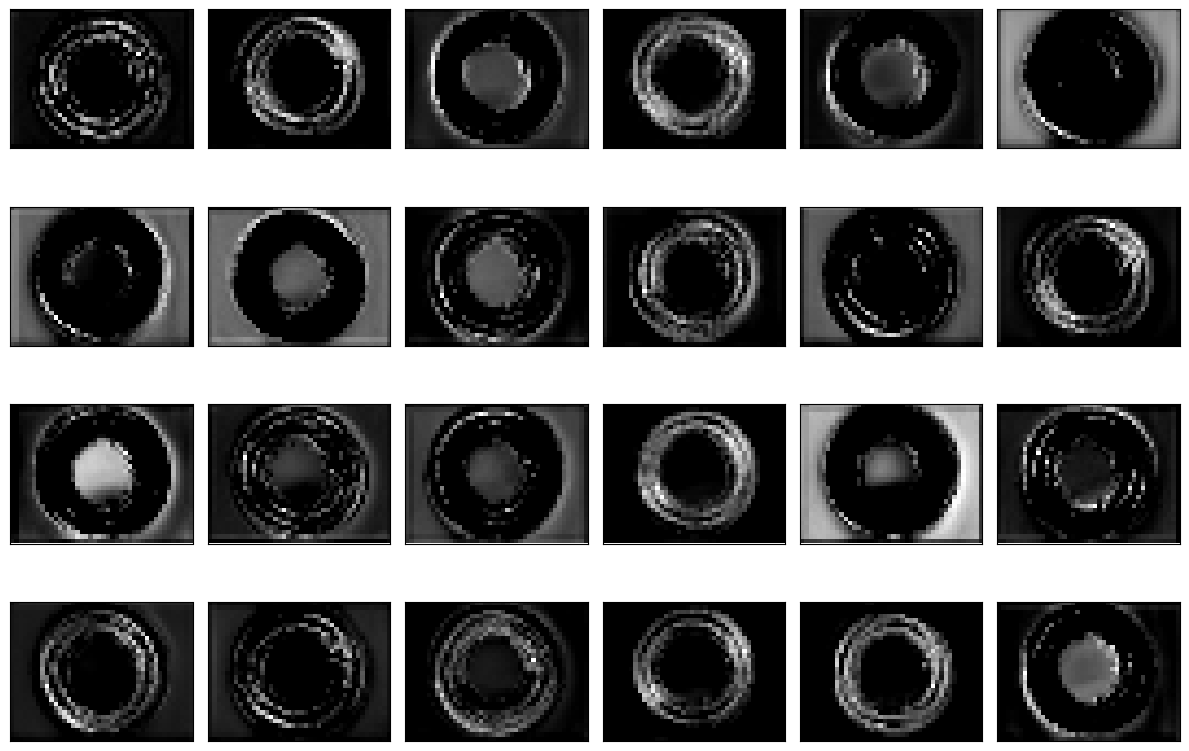

In [71]:
# plot the feature maps from the sub-model output
output_maps = feature_maps[-1]  # get the output from last layer only
n_maps = output_maps.shape[3]
print(output_maps.shape, "maps= ", n_maps)

# print the shape of each feature map
print(np.shape(output_maps[:, :, :, 0]))

# create a new figure
fig = plt.figure(figsize=(12, 12))

# iterate through the filters
for i in range(n_maps):
    # get the filter
    fm = np.squeeze(output_maps[:,:,:,i])

    ax = plt.subplot(int(n_maps/4), int(n_maps/4), i+1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.imshow(fm, cmap='gray')

plt.tight_layout()
plt.show()


## Model Evaluation
Evaluate the model performance by loading in the best trained model from the last saved run.

In [ ]:
# load the trained model and evaluate the model performance
trained_model = tf.keras.models.load_model(os.path.join('./models/', curr_timestamp, 'model.h5'))
loss, acc = trained_model.evaluate(x_test, y_test, verbose=1)
print(f'Trained model, accuracy: {round(100*acc, 2)}%  loss: {round(loss, 4)}')

## Visualize Training Performance
Visualize the training accuracy and loss side-by-side with the validation accuracy and loss.

In [ ]:
# plot the training results
results = json.load(open(os.path.join('./models/', curr_timestamp, 'history.json')))

# create a new figure
fig = plt.figure(figsize=(10, 5))

# subplot 1
ax = plt.subplot(1, 2, 1)
plt.title("Training")
ax.plot(range(1, len(results['accuracy'])+1), results['accuracy'], label='Accuracy')
ax.plot(range(1, len(results['loss'])+1), results['loss'], label='Loss')
ax.set_xlabel("Epochs")
ax.legend()

# subplot 2
ax1 = plt.subplot(1, 2, 2)
plt.title("Validation")
ax1.plot(range(1, len(results['val_accuracy'])+1), results['val_accuracy'], label='Accuracy')
ax1.plot(range(1, len(results['val_loss'])+1), results['val_loss'], label='Loss')
ax1.set_xlabel("Epochs")
ax1.legend()

plt.tight_layout()